<a href="https://colab.research.google.com/github/dguti97/Taller1_ANN/blob/master/Seccion1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395 Redes Neuronales I-2020 </h1>
<H3 align='center'> Tarea 1 Parte 1 - Aproximación universal y tolerancia a ruido </H3>
<h3 align='center'> Maria Jose Apolo Rol: 201573509-3 </h3>
<h3 align='center'> Diego Gutierrez Rol: 201573558-1 </h3>
<hr style="height:2px;border:none"/>

In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import sklearn as skl
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report,f1_score,accuracy_score
from sklearn.datasets import load_breast_cancer
from IPython.display import Image as imagee
from sklearn.utils import shuffle
from numpy import loadtxt
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Input, AveragePooling2D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.optimizers import SGD, rmsprop

In [0]:
from google.colab import drive
drive.mount('/content/drive')

## Para leer es /content/drive/My drive/name

#get_ipython().system_raw("unrar x train_1.rar")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
get_ipython().system_raw("unrar x train_1.rar")

## Dataset Dogs vs Cats Image Classification

Este dataset consiste en 5000 datos que corresponde a imágenes de perros y gatos que vienen clasificadas mediante el nombre del archivo. Este datasets está perfectamente balanceado, teniendo una misma cantidad de fotos de perros como de gatos. 

In [0]:
labels = []  ## 0 cat 1 dog
train_image = []
for i in tqdm(range(2500)):
  if i==247:
    continue
  img = image.load_img('train_1/'+'cat.'+str(i)+'.jpg',grayscale=False,target_size=(200,200))
  img = image.img_to_array(img)
  img = img.astype(np.float32)
  img = img/255
  train_image.append(img)
  labels.append(0)
  img2 = image.load_img('train_1/'+'dog.'+str(i)+'.jpg',grayscale=False,target_size=(200,200))
  img2 = image.img_to_array(img2)
  img2 = img2.astype(np.float32)
  img2 = img2/255
  train_image.append(img2)
  labels.append(1)
    
X = np.array(train_image)
Y=np.array(labels)

100%|██████████| 2500/2500 [00:14<00:00, 171.40it/s]


In [0]:
X,Y = shuffle(X,Y) #Se desordenan las fotos

In [0]:
#se dividen los datos en entrenamiento (4000) y prueba (1000)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2) 

Aproximación Universal
100% Etiquetas random

In [0]:
Y_randomfull = np.array(np.random.randint(0,2,Y_train.shape[0]))

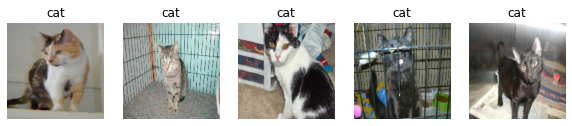

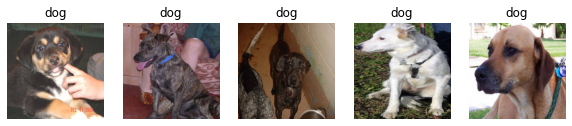

In [0]:
labels2 = ['cat','dog']
def examples(class_number):
    idx_dato = [np.random.choice(np.where(Y_train==class_number)[0]) for i in range(5)]
    f,axx = plt.subplots(1,5,figsize=(10,5))
    for i, dato in enumerate(idx_dato):
        axx[i%5].imshow(X_train[dato])
        axx[i%5].axis('off')
        axx[i%5].set_title(labels2[class_number])
    plt.show()
    
for i in range(2):
    examples(i)

In [0]:
def ruido_principio(Y_train):
  Y_principio = []
  per = [0.10, 0.20, 0.30]
  Y_1 = list()
  for j in range(3):
      for i in range(Y_train.shape[0]):
          if i < math.ceil(Y_train.shape[0]*per[j]):
              if((Y_train[i] == 0)):
                  Y_1.append(1)
              else:
                  Y_1.append(0)
          else:
              Y_1.append(Y_train[i])
      Y_principio.append(np.array(Y_1))
      Y_1 = list()
  Y_principio = np.array(Y_principio)
  return Y_principio

In [0]:
def ruido_final(Y_train):
  Y_final = []
  per = [0.10, 0.20, 0.30]
  Y_1 = list()
  Y_train_T = np.flip(Y_train)
  for j in range(3):
      for i in range(Y_train.shape[0]):
          if i < math.ceil(Y_train_T.shape[0]*per[j]):
              if((Y_train_T[i] == 0)):
                  Y_1.append(1)
              else:
                  Y_1.append(0)
          else:
              Y_1.append(Y_train_T[i])
      Y_1.reverse()
      Y_final.append(np.array(Y_1))
      Y_1 = list()
  Y_final = np.array(Y_final)
  return Y_final

In [0]:
def ruido_medio(Y_train):
  Y_medio = []
  per = [0.10, 0.20, 0.30]
  Y_1 = list()
  n_Y = Y_train.shape[0]
  for j in range(3):
      for i in range(Y_train.shape[0]):
          if i > math.ceil(n_Y/2) and i <= math.ceil(n_Y/2) + math.ceil(n_Y*per[j]):
              if((Y_train[i] == 0)):
                  Y_1.append(1)
              else:
                  Y_1.append(0)
          else:
              Y_1.append(Y_train[i])
      Y_medio.append(np.array(Y_1))
      Y_1 = list()

  Y_medio = np.array(Y_medio)
  return Y_medio

In [0]:
def ruido_random(Y_train):
  Y_random = []
  per = [0.10, 0.20, 0.30]
  Y_1 = list()
  rands = list()
  for i in range(3): 
    randnums= np.random.randint(0,Y_train.shape[0]-1,math.ceil(Y_train.shape[0]*per[i]))
    rands.append(randnums)
  rands = np.array(rands)

  new_array1 = list(Y_train)
  new_array2 = list(Y_train)
  new_array3 = list(Y_train)
  Y_1.append(new_array1)
  Y_1.append(new_array2)
  Y_1.append(new_array3)

  for i in range(rands.shape[0]):
    for j in rands[i]:
      if (Y_1[i][j] == 0):
        Y_1[i][j] = 1
      else:
        Y_1[i][j] = 0
    Y_random.append(Y_1[i])
  Y_random = np.array(Y_random)
  return Y_random


In [0]:
per = [0.10, 0.20, 0.30]

In [0]:
Y_random = ruido_random(Y_train)
Y_medio = ruido_medio(Y_train)
Y_final = ruido_final(Y_train)
Y_principio = ruido_principio(Y_train)

Se tiene: \
Y_train: Todas las etiquetas sin corrupción \
Y_principio: Un arreglo con 10,20,30% de las etiquetas corruptas al principio\
Y_medio: Un arreglo con 10,20,30% de las etiquetas corruptas al medio\
Y_random = Un arreglo con 10,20,30% de las etiquetas corruptas en cualquier lugar\
Y_final: Un arreglo con 10,20,30% de las etiquetas corruptas al final

In [0]:
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
 
# define cnn model
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(200, 200, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model
 
# run the test harness for evaluating a model
def get_model_2(Y_train):
  model = define_model()
  datagen = ImageDataGenerator(featurewise_center=True)
  datagen.fit(X_train)
  # Fit the model on the batches generated by datagen.flow().
  model.fit_generator(datagen.flow(X_train, Y_train, batch_size=56),
                      validation_data=(X_test, Y_test),
                      epochs=5, verbose=1,workers=4)
  prediction = model.predict(X_test)
  return np.around(prediction)


In [0]:
modelo = define_model()
modelo.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
____________________________________________________________

a) Se entrena el modelo utilizando los datos con target 100% aleatorio.

In [0]:
# Se entrena y evalua el modelo
pred=get_model_2(Y_randomfull)
accuracy = accuracy_score(pred,Y_test)
print('Accuracy: %.2f' % (accuracy*100))

58892288/58889256 [==============================] - 6s 0us/step
Epoch 1/5
72/72 [==============================] - 36s 502ms/step - loss: 0.7171 - accuracy: 0.5055 - val_loss: 0.6832 - val_accuracy: 0.5230
Epoch 2/5
72/72 [==============================] - 21s 297ms/step - loss: 0.6933 - accuracy: 0.5265 - val_loss: 0.7150 - val_accuracy: 0.5160
Epoch 3/5
72/72 [==============================] - 22s 303ms/step - loss: 0.6944 - accuracy: 0.5290 - val_loss: 0.6847 - val_accuracy: 0.5260
Epoch 4/5
72/72 [==============================] - 23s 318ms/step - loss: 0.6850 - accuracy: 0.5448 - val_loss: 0.6690 - val_accuracy: 0.6090
Epoch 5/5
72/72 [==============================] - 23s 314ms/step - loss: 0.6849 - accuracy: 0.5513 - val_loss: 0.6713 - val_accuracy: 0.5460
Accuracy: 54.60


b) Se entrena el modelo utilizando los datos sin ruido:

In [0]:
# Se entrena y evalua el modelo
pred=get_model_2(Y_train)
accuracy = accuracy_score(pred,Y_test)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/5
72/72 [==============================] - 27s 376ms/step - loss: 0.4380 - accuracy: 0.7891 - val_loss: 0.2824 - val_accuracy: 0.9000
Epoch 2/5
72/72 [==============================] - 27s 373ms/step - loss: 0.2925 - accuracy: 0.8749 - val_loss: 0.2334 - val_accuracy: 0.9180
Epoch 3/5
72/72 [==============================] - 27s 376ms/step - loss: 0.2399 - accuracy: 0.8997 - val_loss: 0.2149 - val_accuracy: 0.9230
Epoch 4/5
72/72 [==============================] - 27s 379ms/step - loss: 0.2119 - accuracy: 0.9142 - val_loss: 0.1952 - val_accuracy: 0.9280
Epoch 5/5
72/72 [==============================] - 27s 376ms/step - loss: 0.1966 - accuracy: 0.9210 - val_loss: 0.1850 - val_accuracy: 0.9300
Accuracy: 93.00


c) Se entrena el modelo con los datos con ruido introducidos al principio del dataset de entrenamiento. 


In [0]:
for i in range(3):
  pred=get_model_2(Y_principio[i])
  accuracy = accuracy_score(pred,Y_test)
  print('Accuracy para '+str(per[i]*100)+"% es:"+str(accuracy*100)+"\n")

Epoch 1/5
72/72 [==============================] - 27s 381ms/step - loss: 0.6273 - accuracy: 0.6523 - val_loss: 0.4094 - val_accuracy: 0.8480
Epoch 2/5
72/72 [==============================] - 27s 378ms/step - loss: 0.4908 - accuracy: 0.7866 - val_loss: 0.3726 - val_accuracy: 0.8460
Epoch 3/5
72/72 [==============================] - 27s 376ms/step - loss: 0.4610 - accuracy: 0.8079 - val_loss: 0.3363 - val_accuracy: 0.8740
Epoch 4/5
72/72 [==============================] - 27s 376ms/step - loss: 0.4507 - accuracy: 0.8112 - val_loss: 0.4580 - val_accuracy: 0.7470
Epoch 5/5
72/72 [==============================] - 27s 377ms/step - loss: 0.4680 - accuracy: 0.7901 - val_loss: 0.2982 - val_accuracy: 0.9050
Accuracy para 10.0% es:90.5

Epoch 1/5
72/72 [==============================] - 27s 382ms/step - loss: 0.6510 - accuracy: 0.6348 - val_loss: 0.4443 - val_accuracy: 0.8660
Epoch 2/5
72/72 [==============================] - 27s 378ms/step - loss: 0.5860 - accuracy: 0.7044 - val_loss: 0.4266 

d) Se entrena el modelo con los datos con ruido introducidos a la mitad del dataset de entrenamiento. 

In [0]:
for i in range(3):
  pred=get_model_2(Y_medio[i])
  accuracy = accuracy_score(pred,Y_test)
  print('Accuracy para '+str(per[i]*100)+"% es:"+str(accuracy*100)+"\n")

Epoch 1/5
72/72 [==============================] - 27s 378ms/step - loss: 0.5680 - accuracy: 0.7124 - val_loss: 0.4223 - val_accuracy: 0.7890
Epoch 2/5
72/72 [==============================] - 27s 376ms/step - loss: 0.5037 - accuracy: 0.7701 - val_loss: 0.3176 - val_accuracy: 0.8980
Epoch 3/5
72/72 [==============================] - 27s 378ms/step - loss: 0.4502 - accuracy: 0.8117 - val_loss: 0.2996 - val_accuracy: 0.9020
Epoch 4/5
72/72 [==============================] - 27s 375ms/step - loss: 0.4278 - accuracy: 0.8277 - val_loss: 0.2877 - val_accuracy: 0.9130
Epoch 5/5
72/72 [==============================] - 27s 377ms/step - loss: 0.4159 - accuracy: 0.8274 - val_loss: 0.3390 - val_accuracy: 0.8480
Accuracy para 10.0% es:84.8

Epoch 1/5
72/72 [==============================] - 27s 381ms/step - loss: 0.6448 - accuracy: 0.6306 - val_loss: 0.4215 - val_accuracy: 0.8760
Epoch 2/5
72/72 [==============================] - 27s 378ms/step - loss: 0.5795 - accuracy: 0.7174 - val_loss: 0.4018 

e)Se entrena el modelo con los datos con ruido introducidos al final del dataset de entrenamiento.

In [0]:
for i in range(3):
  pred=get_model_2(Y_final[i])
  accuracy = accuracy_score(pred,Y_test)
  print('Accuracy para '+str(per[i]*100)+"% es:"+str(accuracy*100)+"\n")

Epoch 1/5
72/72 [==============================] - 27s 377ms/step - loss: 0.5978 - accuracy: 0.7026 - val_loss: 0.4945 - val_accuracy: 0.7270
Epoch 2/5
72/72 [==============================] - 27s 376ms/step - loss: 0.5033 - accuracy: 0.7764 - val_loss: 0.3371 - val_accuracy: 0.8740
Epoch 3/5
72/72 [==============================] - 27s 377ms/step - loss: 0.4662 - accuracy: 0.8064 - val_loss: 0.2995 - val_accuracy: 0.9160
Epoch 4/5
72/72 [==============================] - 27s 377ms/step - loss: 0.4491 - accuracy: 0.8177 - val_loss: 0.3250 - val_accuracy: 0.8700
Epoch 5/5
72/72 [==============================] - 27s 377ms/step - loss: 0.4424 - accuracy: 0.8184 - val_loss: 0.2982 - val_accuracy: 0.9060
Accuracy para 10.0% es:90.60000000000001

Epoch 1/5
72/72 [==============================] - 28s 382ms/step - loss: 0.6758 - accuracy: 0.5873 - val_loss: 0.5028 - val_accuracy: 0.7890
Epoch 2/5
72/72 [==============================] - 27s 378ms/step - loss: 0.5986 - accuracy: 0.7021 - val_

f) Se entrena el modelo con los datos con ruidos introducidos de forma aleatoria en el dataset de entrenamiento. 

In [0]:
for i in range(3):
  pred=get_model_2(Y_random[i])
  accuracy = accuracy_score(pred,Y_test)
  print('Accuracy para '+str(per[i]*100)+"% es:"+str(accuracy*100)+"\n")

Epoch 1/5
72/72 [==============================] - 28s 382ms/step - loss: 0.5796 - accuracy: 0.7079 - val_loss: 0.3543 - val_accuracy: 0.8860
Epoch 2/5
72/72 [==============================] - 27s 378ms/step - loss: 0.4810 - accuracy: 0.7854 - val_loss: 0.3647 - val_accuracy: 0.8380
Epoch 3/5
72/72 [==============================] - 27s 374ms/step - loss: 0.4385 - accuracy: 0.8204 - val_loss: 0.2957 - val_accuracy: 0.9090
Epoch 4/5
72/72 [==============================] - 27s 377ms/step - loss: 0.4099 - accuracy: 0.8407 - val_loss: 0.2862 - val_accuracy: 0.9170
Epoch 5/5
72/72 [==============================] - 27s 376ms/step - loss: 0.4138 - accuracy: 0.8279 - val_loss: 0.2841 - val_accuracy: 0.9020
Accuracy para 10.0% es:90.2

Epoch 1/5
72/72 [==============================] - 27s 382ms/step - loss: 0.6302 - accuracy: 0.6543 - val_loss: 0.4235 - val_accuracy: 0.8700
Epoch 2/5
72/72 [==============================] - 27s 377ms/step - loss: 0.5541 - accuracy: 0.7316 - val_loss: 0.4166 

##  Resultados

a) Sin ruido

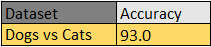

In [0]:
imagee(filename='Screenshot_34.png')

b) Con ruido

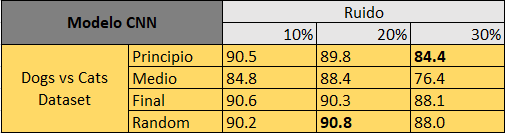

In [0]:
imagee(filename='Screenshot_31.png')

A partir de la tabla anterior, se observa que la peor accuracy se obtuvo al introducir ruido al principio del conjunto de entrenamiento, particularmente un 30% de este. Esto se podría ocasionar por el fenómeno de error de arrastre, que afectan los resultados posteriores a las etiquetas corruptas. Además de el impacto que tiene el que se ingresen todas las etiquetas corruptas juntas.
Por otra parte, la mejor accuracy se obtuvo agregando ruido de forma aleatoria dentro del dataset, donde se observa que al estar uniformemente distribuidas las etiquetas corruptases menor el impacto sin importar la cantidad de estas etiquetas que se ingresen. 

## 2) Dataset Breast Cancer Wisconsin

Este es un dataset bien conocido, que consiste en la detección de células cancerígenas a partir de una serie de características obtenidas al analizar una biopsia de absorción de tejido o fluidos de esa zona. Este es un dataset pequeño, que cuenta con 569 datos (212 beningnos y 257 malignos).

In [0]:
from sklearn.model_selection import train_test_split
X_train,y_train = load_breast_cancer(return_X_y=True)
scaler = skl.preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, y_train, test_size=0.2)

In [0]:
Y_randomfull = np.array(np.random.randint(0,2,Y_train.shape[0]))

In [0]:
Y_random = ruido_random(Y_train)
Y_medio = ruido_medio(Y_train)
Y_final = ruido_final(Y_train)
Y_principio = ruido_principio(Y_train)

El modelo utilizado es una red neuronal feed-forward que posee:

*   1 capa de entrada de 12 neuronas con función de activación RELU.
*   2 capas ocultas de 12 y 8 neuronas respectivamente ambas con función de activación RELU.
*   1 capa de salida sigmoidal de una neurona.

Para la función de pérdida se utilizó la binary crossentropy y para entrenar se utilizó el optimizador 'adam', que corresponde a un algoritmo de gradiente descendiente estocástico muy eficiente. Este optimizador auto sintoniza sus parámetros y entrega buenos resultados para un gran rango de problemas. 


In [0]:
def get_model_1():
  model = Sequential()
  model.add(Dense(12, input_dim= X_train.shape[1], activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

Se entrena el modelo utilizando los datos 100% corruptos (Teorema de aproximación universal)

In [0]:
# Se entrena y evalua el modelo
model = get_model_1()
model.fit(X_train, Y_randomfull, epochs=150, batch_size=10, verbose=0)
_, accuracy = model.evaluate(X_test, Y_test)
print('Accuracy: %.2f' % (accuracy*100))

114/114 [==============================] - 0s 230us/step
Accuracy: 52.63


a) Se entrena el modelo utilizando los datos sin ruido:

In [0]:
model = get_model_1()
model.fit(X_train, Y_train, epochs=150, batch_size=10, verbose=0)

In [0]:
# Se evalua el modelo
_, accuracy = model.evaluate(X_test, Y_test)
print('Accuracy: %.2f' % (accuracy*100))

114/114 [==============================] - 0s 250us/step
Accuracy: 98.25


b) Se entrena el modelo con los datos con ruido introducidos en el dataset de entrenamiento. 


In [0]:
mensajes = ['al principio', 'al final', 'en medio', 'en filas random']
Y_arr = [Y_principio, Y_final, Y_medio, Y_random]
for j in range(4):
  print('Ruido introducido '+mensajes[j]+' del dataset de entrenamiento\n')
  for i in range(3):
    model = get_model_1()
    model.fit(X_train, (Y_arr[j])[i], epochs=150, batch_size=10, verbose=0)
    _, accuracy = model.evaluate(X_test, Y_test)
    print('Accuracy para '+str(per[i]*100)+"% es:"+str(accuracy*100)+"\n")
  print("-------------------------------------------------\n")

Ruido introducido al principiodel dataset de entrenamiento

114/114 [==============================] - 0s 241us/step
Accuracy para 10.0% es:86.84210777282715

114/114 [==============================] - 0s 245us/step
Accuracy para 20.0% es:82.45614171028137

114/114 [==============================] - 0s 244us/step
Accuracy para 30.0% es:76.31579041481018

-------------------------------------------------

Ruido introducido al finaldel dataset de entrenamiento

114/114 [==============================] - 0s 237us/step
Accuracy para 10.0% es:92.98245906829834

114/114 [==============================] - 0s 247us/step
Accuracy para 20.0% es:84.21052694320679

114/114 [==============================] - 0s 252us/step
Accuracy para 30.0% es:66.66666865348816

-------------------------------------------------

Ruido introducido en mediodel dataset de entrenamiento

114/114 [==============================] - 0s 251us/step
Accuracy para 10.0% es:91.22806787490845

114/114 [========================

## Resultados

a) Sin ruido

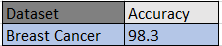

In [0]:
imagee(filename='Screenshot_35.png')


b) Con ruido

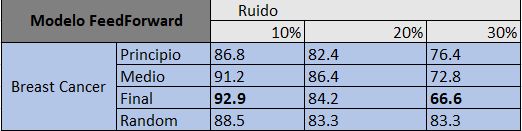

In [0]:
imagee(filename='Screenshot_38.png')

En primer lugar, se puede observar que a nivel general, la accuracy es menor a la entregada por el dataset anterior. Esto se puede explicar por la baja cantidad de datos que posee el dataset en comparación al anterior. 
Por otro lado, la mejor accuracy se obtuvo introduciendo los datos corruptos en una baja cantidad al final del dataset. Además, se puede ver que al aumentar este ruido al 30% se obtiene la peor accuracy. Esto se debe a que cuando el ruido no está distribuido uniformemente, afecta en gran manera el porcentaje de datos corruptos. 

## Dataset Sintético


In [0]:
X,Y=skl.datasets.make_classification(n_samples=2000, n_features=20, n_informative=2, n_redundant=2, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)

In [0]:
scaler = skl.preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [0]:
Y_random = ruido_random(Y_train)
Y_medio = ruido_medio(Y_train)
Y_final = ruido_final(Y_train)
Y_principio = ruido_principio(Y_train)

Se entrena el dataset utilizando 100% de etiquetas aleatorias para verificar el teorema de aproximación universal

In [0]:
# Se entrena y evalua el modelo
Y_randomfull = np.array(np.random.randint(0,2,Y_train.shape[0]))
model = get_model_1()
model.fit(X_train, Y_randomfull, epochs=150, batch_size=10, verbose=0)
_, accuracy = model.evaluate(X_test, Y_test)
print('Accuracy: %.2f' % (accuracy*100))

400/400 [==============================] - 0s 129us/step
Accuracy: 53.50


a) Se entrena el modelo con los datos sin ruido en el dataset de entrenamiento. 

In [0]:
model = get_model_1()
model.fit(X_train, Y_train, epochs=50, batch_size=10, verbose=0)

In [0]:
# Se evalua el modelo
_, accuracy = model.evaluate(X_test, Y_test)
print('Accuracy: %.2f' % (accuracy*100))

400/400 [==============================] - 0s 152us/step
Accuracy: 87.75


b) Se entrena el modelo con los datos con ruido introducidos en el dataset de entrenamiento. 

In [0]:
mensajes = ['al principio', 'al final', 'en medio', 'en filas random']
Y_arr = [Y_principio, Y_final, Y_medio, Y_random]
for j in range(4):
  print('Ruido introducido '+mensajes[j]+' del dataset de entrenamiento\n')
  for i in range(3):
    model = get_model_1()
    model.fit(X_train, (Y_arr[j])[i], epochs=50, batch_size=10, verbose=0)
    _, accuracy = model.evaluate(X_test, Y_test)
    print('Accuracy para '+str(per[i]*100)+"% es:"+str(accuracy*100)+"\n")
  print("-------------------------------------------------\n")

Ruido introducido al principio del dataset de entrenamiento

400/400 [==============================] - 0s 146us/step
Accuracy para 10.0% es:88.49999904632568

400/400 [==============================] - 0s 121us/step
Accuracy para 20.0% es:84.24999713897705

400/400 [==============================] - 0s 120us/step
Accuracy para 30.0% es:75.24999976158142

-------------------------------------------------

Ruido introducido al final del dataset de entrenamiento

400/400 [==============================] - 0s 130us/step
Accuracy para 10.0% es:85.75000166893005

400/400 [==============================] - 0s 138us/step
Accuracy para 20.0% es:83.74999761581421

400/400 [==============================] - 0s 118us/step
Accuracy para 30.0% es:80.0000011920929

-------------------------------------------------

Ruido introducido en medio del dataset de entrenamiento

400/400 [==============================] - 0s 124us/step
Accuracy para 10.0% es:87.5

400/400 [==============================] - 0

## Resultados 

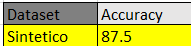

In [0]:
imagee(filename='Screenshot_39.png')


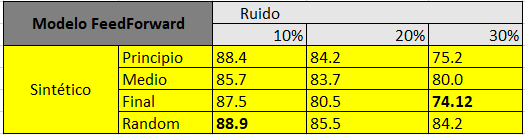

In [0]:
imagee(filename='Screenshot_37.png')


Analizando los resultados, se puede apreciar que hay valores incluso mayores al accuracy sin ruido, esto puede ser debido a que al introducir ruido se pudo haber disminuido el overfitting a la hora de entrenar la red. 
Por otro lado, el mejor resultado se obtuvo ingresando las etiquetas en forma random en una magnitud del 10%. Además, los peores resultados fueron ingresando los valores al principio y al final en una magnitud del 30% con una disminuición de 13% de accuracy aproximadamente. 